First 5 rows of the DataFrame:
              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB

Missing values:
co2    59
dtype: int64

Descriptive Statistics:
               co2
count  2225.000000
mean    340.142247
std      17.003885
min     313.000000
25%     324.800000
50%     338.300000
75%     354.800000
max     373.900000


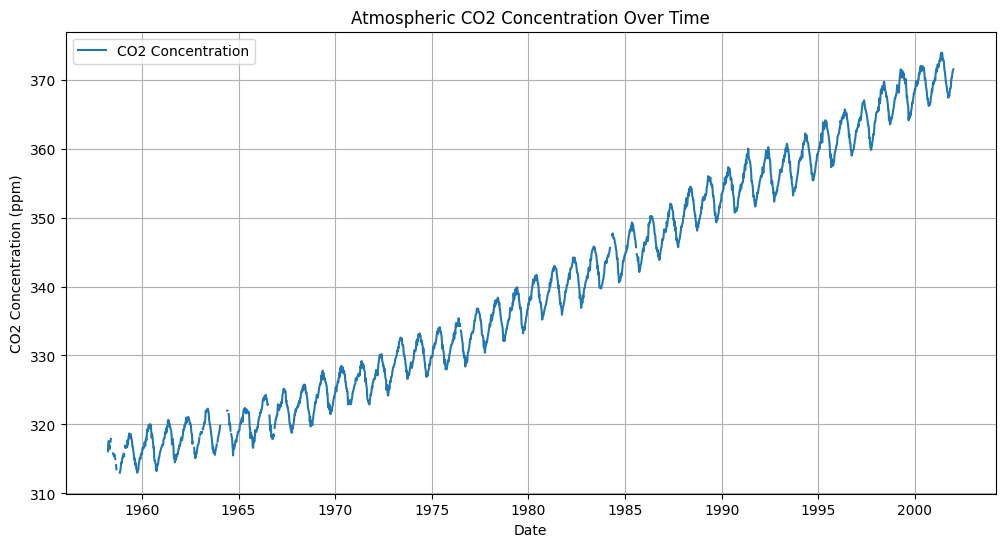

In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = sm.datasets.co2.load()
df = data.data
print("First 5 rows of the DataFrame:")
print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())
print("\nDescriptive Statistics:")
print(df.describe())
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['co2'], label='CO2 Concentration')
plt.title('Atmospheric CO2 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
print("Missing values before interpolation:")
print(df.isnull().sum())
df['co2_imputed'] = df['co2'].interpolate(method='linear')
print("\nMissing values after interpolation:")
print(df['co2_imputed'].isnull().sum())

scaler = MinMaxScaler(feature_range=(0, 1))
df['co2_scaled'] = scaler.fit_transform(df[['co2_imputed']])
print("\nFirst 5 rows with imputed and scaled CO2 data:")
print(df.head())
sequence_length = 52  

X = []
y = []
for i in range(len(df['co2_scaled']) - sequence_length):
    X.append(df['co2_scaled'].iloc[i : (i + sequence_length)].values)
    y.append(df['co2_scaled'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"\nShape of X (input sequences): {X.shape}")
print(f"Shape of y (target values): {y.shape}")

print("Data preprocessing and windowing complete.")

Missing values before interpolation:
co2    59
dtype: int64

Missing values after interpolation:
0

First 5 rows with imputed and scaled CO2 data:
              co2  co2_imputed  co2_scaled
1958-03-29  316.1        316.1    0.050903
1958-04-05  317.3        317.3    0.070608
1958-04-12  317.6        317.6    0.075534
1958-04-19  317.5        317.5    0.073892
1958-04-26  316.4        316.4    0.055829

Shape of X (input sequences): (2232, 52)
Shape of y (target values): (2232,)
Data preprocessing and windowing complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.dot(uit, self.u)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
input_sequence = Input(shape=(X.shape[1], 1), name='input_sequence')
lstm_out = LSTM(units=50, return_sequences=True, name='lstm_layer')(input_sequence)
attention_out = Attention(name='attention_layer')(lstm_out)
output_pred = Dense(units=1, activation='linear', name='output_layer')(attention_out)
attention_lstm_model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model')
attention_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nAttention-based LSTM Model Summary:")
attention_lstm_model.summary()


Attention-based LSTM Model Summary:


Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)     │ (None, 52, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 52, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer (Attention)     │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,051 (50.98 KB)

 Trainable params: 13,051 (50.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
baseline_input_sequence = Input(shape=(X.shape[1], 1), name='baseline_input_sequence')
lstm_out_baseline = LSTM(units=50, return_sequences=False, name='baseline_lstm_layer')(baseline_input_sequence)
output_pred_baseline = Dense(units=1, activation='linear', name='baseline_output_layer')(lstm_out_baseline)
baseline_lstm_model = Model(inputs=baseline_input_sequence, outputs=output_pred_baseline, name='Baseline_LSTM_Model')
baseline_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nBaseline LSTM Model Summary:")
baseline_lstm_model.summary()


Baseline LSTM Model Summary:


Model: "Baseline_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ baseline_input_sequence         │ (None, 52, 1)          │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_lstm_layer (LSTM)      │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_output_layer (Dense)   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Original X shape: {X.shape}")
print(f"Reshaped X shape: {X_reshaped.shape}")
split_index = int(len(X_reshaped) * split_ratio)

X_train, X_val = X_reshaped[:split_index], X_reshaped[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print(f"\nTraining data shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Validation data shape (X_val, y_val): {X_val.shape}, {y_val.shape}")

Original X shape: (2232, 52)
Reshaped X shape: (2232, 52, 1)

Training data shape (X_train, y_train): (1785, 52, 1), (1785,)
Validation data shape (X_val, y_val): (447, 52, 1), (447,)


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_sequence = Input(shape=(X_train.shape[1], 1), name='input_sequence')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer')(input_sequence)
    attention_out = Attention(name='attention_layer')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer')(attention_out)

    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
tuner = kt.RandomSearch(
    build_attention_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='attention_lstm_tuning'
)
print("\nStarting hyperparameter search for Attention-based LSTM model...")
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)
best_attention_model = tuner.get_best_models(num_models=1)[0]

print("\nBest Attention-based LSTM Model Summary:")
best_attention_model.summary()

print("\nTraining the best model with full training data (or further training if desired)...")
history_attention = best_attention_model.fit(
    X_train, y_train,
    epochs=50, # Train for more epochs with the best hyperparameters
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("Hyperparameter optimization and training for Attention-based LSTM model complete.")

Trial 5 Complete [00h 00m 29s]
val_loss: 0.00022197916405275464

Best val_loss So Far: 0.00019470522238407284
Total elapsed time: 00h 02m 33s

Best Attention-based LSTM Model Summary:


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)     │ (None, 52, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer (Attention)     │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the best model with full training data (or further training if desired)...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0019 - val_loss: 4.4342e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.5804e-04 - val_loss: 7.2759e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.4094e-04 - val_loss: 0.0011
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.6378e-04 - val_loss: 0.0012
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.5745e-04 - val_loss: 5.3978e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.6481e-04 - val_loss: 5.1908e-04
Hyperparameter optimization and training for Attention-based LSTM model complete.


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_sequence = Input(shape=(X_train.shape[1], 1), name='input_sequence')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer')(input_sequence)
    attention_out = Attention(name='attention_layer')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer')(attention_out)

    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
tuner = kt.RandomSearch(
    build_attention_model,
    objective='val_loss',
    max_trials=5,  
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='attention_lstm_tuning'
)

print("\nStarting hyperparameter search for Attention-based LSTM model...")
tuner.search(
    X_train, y_train,
    epochs=10, 
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

best_attention_model = tuner.get_best_models(num_models=1)[0]

print("\nBest Attention-based LSTM Model Summary:")
best_attention_model.summary()

print("\nTraining the best model with full training data (or further training if desired)...")
history_attention = best_attention_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("Hyperparameter optimization and training for Attention-based LSTM model complete.")

Reloading Tuner from keras_tuner_dir\attention_lstm_tuning\tuner0.json

Starting hyperparameter search for Attention-based LSTM model...

Best Attention-based LSTM Model Summary:


Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)     │ (None, 52, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer (Attention)     │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the best model with full training data (or further training if desired)...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0026 - val_loss: 2.3141e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.8999e-04 - val_loss: 2.8350e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 1.5009e-04 - val_loss: 6.4828e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 1.5579e-04 - val_loss: 0.0013
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.3582e-04 - val_loss: 4.4417e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.3968e-04 - val_loss: 0.0012
Hyperparameter optimization and training for Attention-based LSTM model complete.


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_sequence = Input(shape=(X_train.shape[1], 1), name='input_sequence')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer')(input_sequence)
    attention_out = Attention(name='attention_layer')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer')(attention_out)

    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_attention_model,
    objective='val_loss',
    max_trials=5, 
    executions_per_trial=1, 
    directory='keras_tuner_dir',
    project_name='attention_lstm_tuning'
)

print("\nStarting hyperparameter search for Attention-based LSTM model...")
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

best_attention_model = tuner.get_best_models(num_models=1)[0]

print("\nBest Attention-based LSTM Model Summary:")
best_attention_model.summary()

print("\nTraining the best model with full training data (or further training if desired)...")
history_attention = best_attention_model.fit(
    X_train, y_train,
    epochs=50, # Train for more epochs with the best hyperparameters
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("Hyperparameter optimization and training for Attention-based LSTM model complete.")

Reloading Tuner from keras_tuner_dir\attention_lstm_tuning\tuner0.json

Starting hyperparameter search for Attention-based LSTM model...

Best Attention-based LSTM Model Summary:


Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)     │ (None, 52, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer (Attention)     │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the best model with full training data (or further training if desired)...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 2.0016e-04 - val_loss: 6.5464e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 1.8197e-04 - val_loss: 4.7165e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.5567e-04 - val_loss: 6.1151e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.4975e-04 - val_loss: 7.6175e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.5536e-04 - val_loss: 8.3025e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.6374e-04 - val_loss: 8.0357e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.7001e-04 - val_loss: 5.1076e-04
Hyperparameter optimization and training for Attention-based LSTM model complete.


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_sequence = Input(shape=(X_train.shape[1], 1), name='input_sequence')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer')(input_sequence)
    attention_out = Attention(name='attention_layer')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer')(attention_out)

    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_attention_model,
    objective='val_loss',
    max_trials=5, 
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='attention_lstm_tuning'
)


print("\nStarting hyperparameter search for Attention-based LSTM model...")
tuner.search(
    X_train, y_train,
    epochs=10, 
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

best_attention_model = tuner.get_best_models(num_models=1)[0]

print("\nBest Attention-based LSTM Model Summary:")
best_attention_model.summary()

print("\nTraining the best model with full training data (or further training if desired)...")
history_attention = best_attention_model.fit(
    X_train, y_train,
    epochs=50, 
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("Hyperparameter optimization and training for Attention-based LSTM model complete.")

Reloading Tuner from keras_tuner_dir\attention_lstm_tuning\tuner0.json

Starting hyperparameter search for Attention-based LSTM model...

Best Attention-based LSTM Model Summary:


Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)     │ (None, 52, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer (Attention)     │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the best model with full training data (or further training if desired)...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0030 - val_loss: 2.7382e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 1.7336e-04 - val_loss: 3.8049e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 1.5828e-04 - val_loss: 8.0555e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.3886e-04 - val_loss: 0.0011
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.7502e-04 - val_loss: 9.6452e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.5244e-04 - val_loss: 8.3316e-04
Hyperparameter optimization and training for Attention-based LSTM model complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
baseline_input_sequence = Input(shape=(X_train.shape[1], 1), name='baseline_input_sequence')
lstm_out_baseline = LSTM(units=50, return_sequences=False, name='baseline_lstm_layer')(baseline_input_sequence)
output_pred_baseline = Dense(units=1, activation='linear', name='baseline_output_layer')(lstm_out_baseline)
baseline_lstm_model = Model(inputs=baseline_input_sequence, outputs=output_pred_baseline, name='Baseline_LSTM_Model')
baseline_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nBaseline LSTM Model Summary:")
baseline_lstm_model.summary()
print("\nTraining the Baseline LSTM model...")
history_baseline = baseline_lstm_model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("Baseline LSTM model training complete.")



Baseline LSTM Model Summary:


Model: "Baseline_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ baseline_input_sequence         │ (None, 52, 1)          │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_lstm_layer (LSTM)      │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_output_layer (Dense)   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training the Baseline LSTM model...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0102 - val_loss: 0.0021
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.2414e-04 - val_loss: 9.7170e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 5.2426e-04 - val_loss: 9.4041e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.9495e-04 - val_loss: 6.2709e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.6629e-04 - val_loss: 6.4303e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 4.2498e-04 - val_loss: 9.2021e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.0080e-04 - val_loss: 4.2984e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.5433e-04 - val_loss: 4.2116e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.2341e-04 - val_loss: 3.1671e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.8732e-04 - val_loss: 2.6034e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

attention_predictions_scaled = best_attention_model.predict(X_val)
baseline_predictions_scaled = baseline_lstm_model.predict(X_val)
attention_predictions = scaler.inverse_transform(attention_predictions_scaled).flatten()
baseline_predictions = scaler.inverse_transform(baseline_predictions_scaled).flatten()
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    return rmse, mae, mape

rmse_att, mae_att, mape_att = calculate_metrics(y_val_original, attention_predictions, "Attention-based LSTM")
rmse_base, mae_base, mape_base = calculate_metrics(y_val_original, baseline_predictions, "Baseline LSTM")

print("\nModel evaluation complete.")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

--- Attention-based LSTM Performance ---
RMSE: 1.0077
MAE: 0.7734
MAPE: 0.2120%

--- Baseline LSTM Performance ---
RMSE: 0.7436
MAE: 0.6077
MAPE: 0.1666%

Model evaluation complete.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import tensorflow as tf

initial_train_size = int(len(X_reshaped) * 0.7)
step_size = sequence_length 

attention_predictions_cv = []
baseline_predictions_cv = []
actual_values_cv = []

print(f"Total data points: {len(X_reshaped)}")
print(f"Initial training set size: {initial_train_size}")
print(f"Step size for advancing origin: {step_size}")
print(f"Number of sequences for prediction: {len(X_reshaped) - initial_train_size - 1}")
print("Setup complete for rolling-origin cross-validation.")

Total data points: 2232
Initial training set size: 1562
Step size for advancing origin: 52
Number of sequences for prediction: 669
Setup complete for rolling-origin cross-validation.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model_for_cv(lstm_units, learning_rate):
    input_sequence = Input(shape=(X_reshaped.shape[1], 1), name='input_sequence_cv')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer_cv')(input_sequence)
    attention_out = Attention(name='attention_layer_cv')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer_cv')(attention_out)
    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model_CV')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_baseline_model_for_cv():
    baseline_input_sequence = Input(shape=(X_reshaped.shape[1], 1), name='baseline_input_sequence_cv')
    lstm_out_baseline = LSTM(units=50, return_sequences=False, name='baseline_lstm_layer_cv')(baseline_input_sequence)
    output_pred_baseline = Dense(units=1, activation='linear', name='baseline_output_layer_cv')(lstm_out_baseline)
    model = Model(inputs=baseline_input_sequence, outputs=output_pred_baseline, name='Baseline_LSTM_Model_CV')
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lstm_units = best_hps.get('lstm_units')
best_learning_rate = best_hps.get('learning_rate')

print(f"Best Attention Model Hyperparameters: LSTM Units={best_lstm_units}, Learning Rate={best_learning_rate}")

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    return rmse, mae, mape

print("\nStarting Rolling-Origin Cross-Validation...")

for train_index in range(initial_train_size, len(X_reshaped), step_size):
    predict_end_index = min(train_index + step_size, len(X_reshaped))
    if train_index >= len(X_reshaped):
        print(f"No more data for training at index {train_index}.")
        break
    if predict_end_index <= train_index:
        print(f"No data left to predict after index {train_index}.")
        break
    X_train_fold = X_reshaped[:train_index]
    y_train_fold = y[:train_index]
    X_test_fold = X_reshaped[train_index:predict_end_index]
    y_test_fold = y[train_index:predict_end_index]

    if X_train_fold.shape[0] < sequence_length:
        print(f"Skipping fold starting at {train_index} due to insufficient training data size: {X_train_fold.shape[0]}.")
        continue
    if X_test_fold.shape[0] == 0:
        print(f"Skipping fold starting at {train_index} due to no test data.")
        continue

    print(f"\n--- Fold starting at {train_index} (Train size: {X_train_fold.shape[0]}, Test size: {X_test_fold.shape[0]}) ---")
    attention_model_fold = build_attention_model_for_cv(best_lstm_units, best_learning_rate)
    print(f"Training Attention Model for fold {train_index}...")
    attention_model_fold.fit(X_train_fold, y_train_fold,
                            epochs=10,
                            batch_size=32,
                            verbose=0,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])
    attention_predictions_scaled_fold = attention_model_fold.predict(X_test_fold, verbose=0)
    baseline_model_fold = build_baseline_model_for_cv()
    print(f"Training Baseline Model for fold {train_index}...")
    baseline_model_fold.fit(X_train_fold, y_train_fold,
                           epochs=10,
                           batch_size=32,
                           verbose=0,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])
    baseline_predictions_scaled_fold = baseline_model_fold.predict(X_test_fold, verbose=0)
    attention_predictions_cv.extend(scaler.inverse_transform(attention_predictions_scaled_fold).flatten())
    baseline_predictions_cv.extend(scaler.inverse_transform(baseline_predictions_scaled_fold).flatten())
    actual_values_cv.extend(scaler.inverse_transform(y_test_fold.reshape(-1, 1)).flatten())

print("\nRolling-Origin Cross-Validation complete.")

actual_values_cv = np.array(actual_values_cv)
attention_predictions_cv = np.array(attention_predictions_cv)
baseline_predictions_cv = np.array(baseline_predictions_cv)
actual_values_cv[actual_values_cv == 0] = np.finfo(float).eps

rmse_att_cv, mae_att_cv, mape_att_cv = calculate_metrics(actual_values_cv, attention_predictions_cv, "Attention-based LSTM (Rolling CV)")
rmse_base_cv, mae_base_cv, mape_base_cv = calculate_metrics(actual_values_cv, baseline_predictions_cv, "Baseline LSTM (Rolling CV)")

Best Attention Model Hyperparameters: LSTM Units=64, Learning Rate=0.01

Starting Rolling-Origin Cross-Validation...

--- Fold starting at 1562 (Train size: 1562, Test size: 52) ---
Training Attention Model for fold 1562...
Training Baseline Model for fold 1562...

--- Fold starting at 1614 (Train size: 1614, Test size: 52) ---
Training Attention Model for fold 1614...
Training Baseline Model for fold 1614...

--- Fold starting at 1666 (Train size: 1666, Test size: 52) ---
Training Attention Model for fold 1666...
Training Baseline Model for fold 1666...

--- Fold starting at 1718 (Train size: 1718, Test size: 52) ---
Training Attention Model for fold 1718...
Training Baseline Model for fold 1718...

--- Fold starting at 1770 (Train size: 1770, Test size: 52) ---
Training Attention Model for fold 1770...
Training Baseline Model for fold 1770...

--- Fold starting at 1822 (Train size: 1822, Test size: 52) ---
Training Attention Model for fold 1822...
Training Baseline Model for fold 182

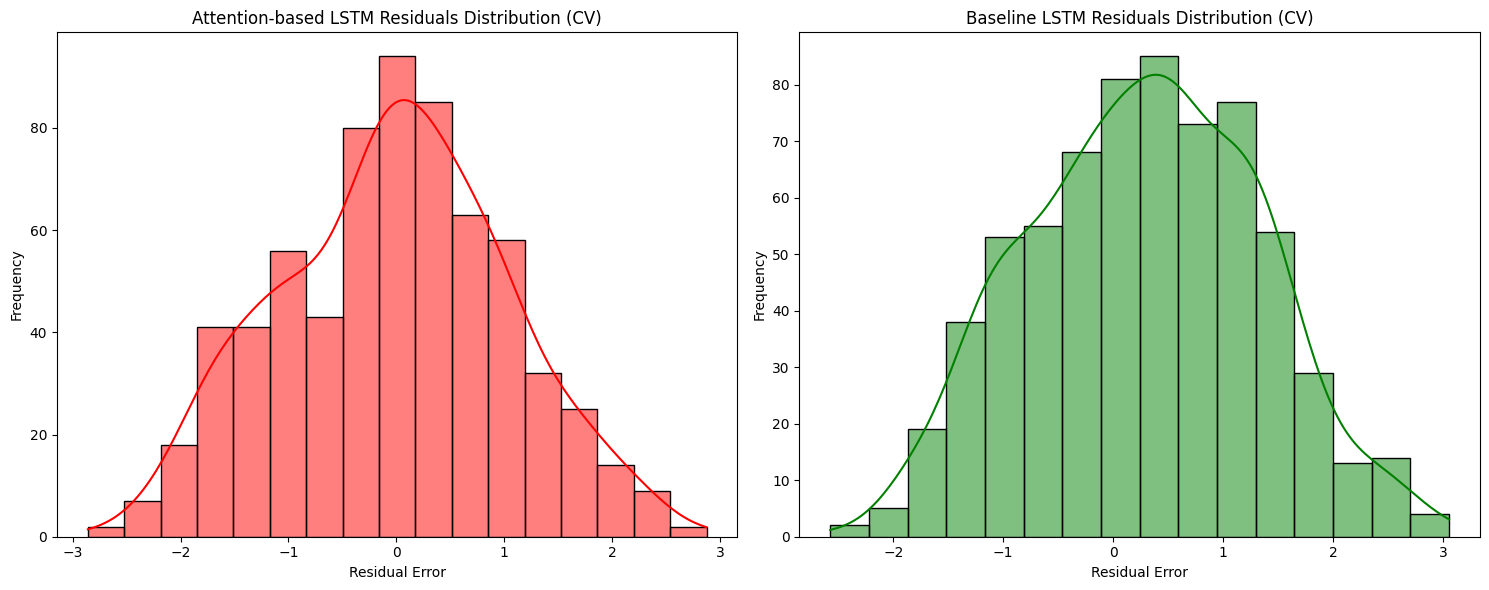

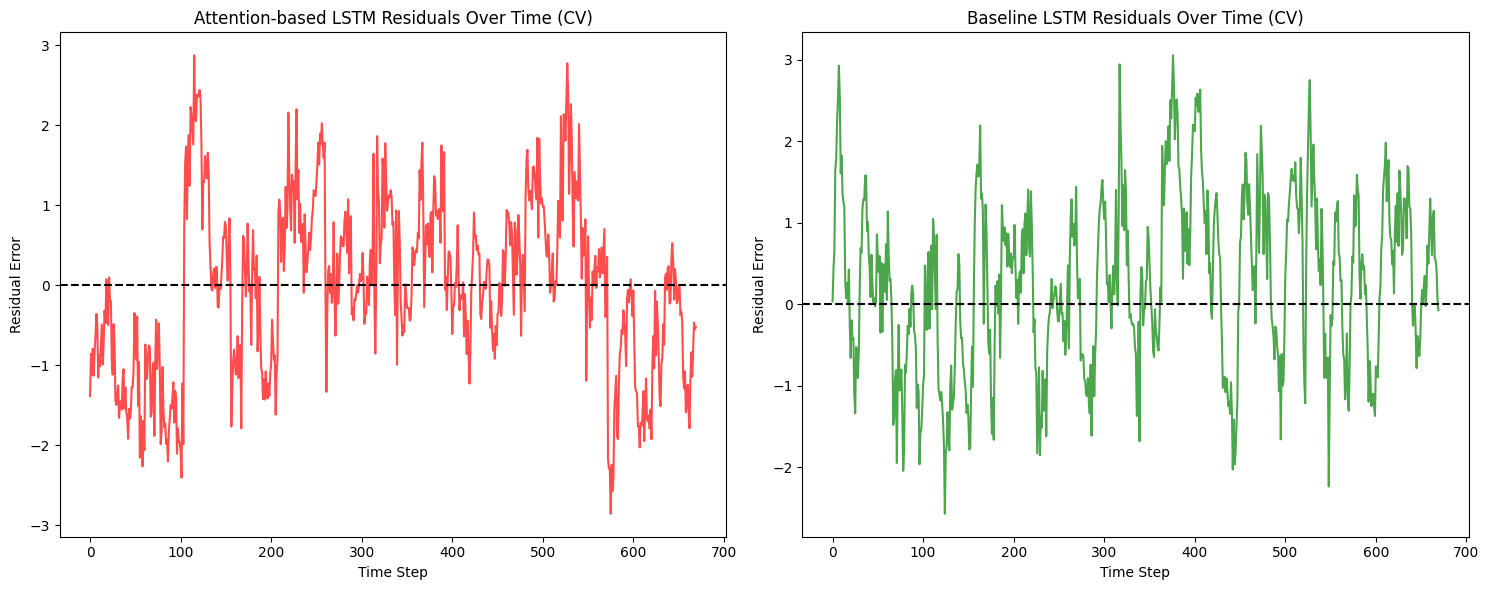

Residual analysis visualization complete.


In [ ]:
attention_residuals_cv = actual_values_cv - attention_predictions_cv
baseline_residuals_cv = actual_values_cv - baseline_predictions_cv
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(attention_residuals_cv, kde=True, color='red')
plt.title('Attention-based LSTM Residuals Distribution (CV)')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(baseline_residuals_cv, kde=True, color='green')
plt.title('Baseline LSTM Residuals Distribution (CV)')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(attention_residuals_cv, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Attention-based LSTM Residuals Over Time (CV)')
plt.xlabel('Time Step')
plt.ylabel('Residual Error')

plt.subplot(1, 2, 2)
plt.plot(baseline_residuals_cv, color='green', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Baseline LSTM Residuals Over Time (CV)')
plt.xlabel('Time Step')
plt.ylabel('Residual Error')
plt.tight_layout()
plt.show()

print("Residual analysis visualization complete.")

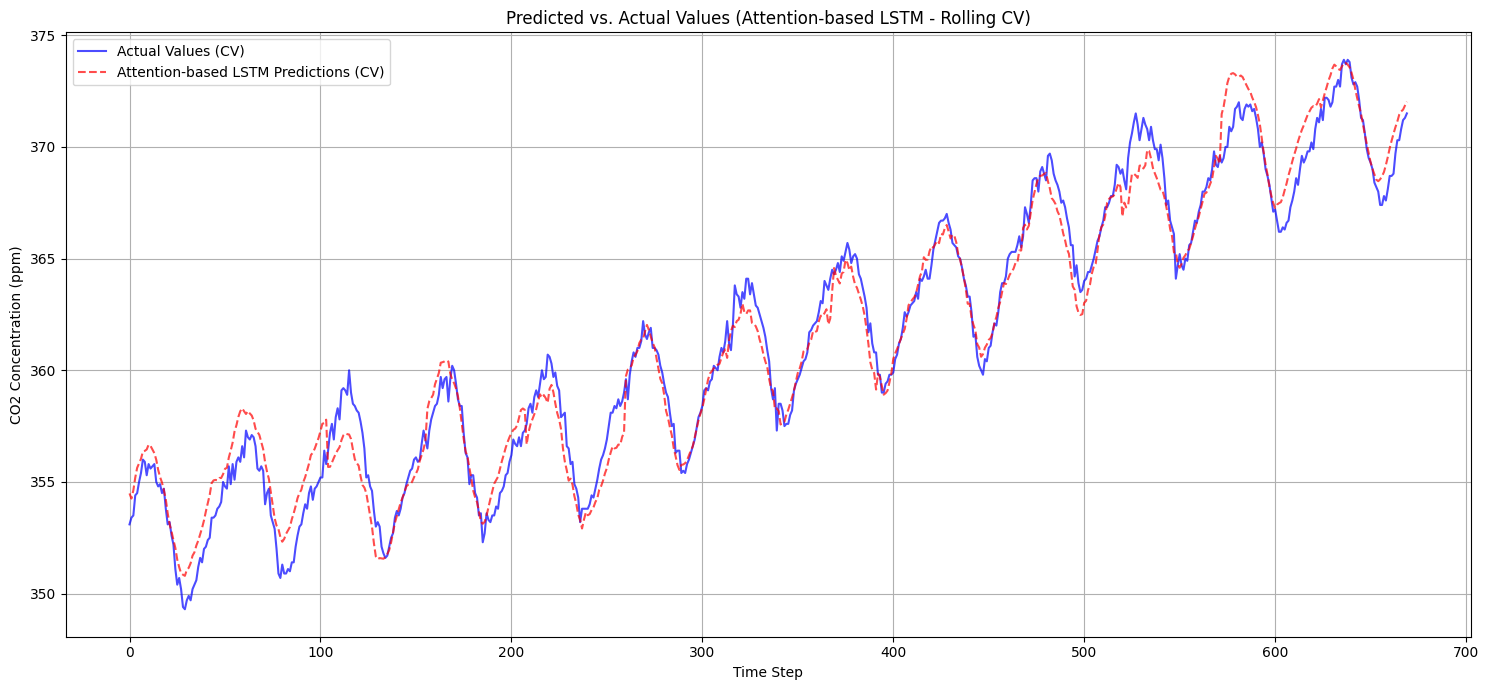

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(actual_values_cv, label='Actual Values (CV)', color='blue', alpha=0.7)
plt.plot(attention_predictions_cv, label='Attention-based LSTM Predictions (CV)', color='red', linestyle='--', alpha=0.7)
plt.title('Predicted vs. Actual Values (Attention-based LSTM - Rolling CV)')
plt.xlabel('Time Step')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

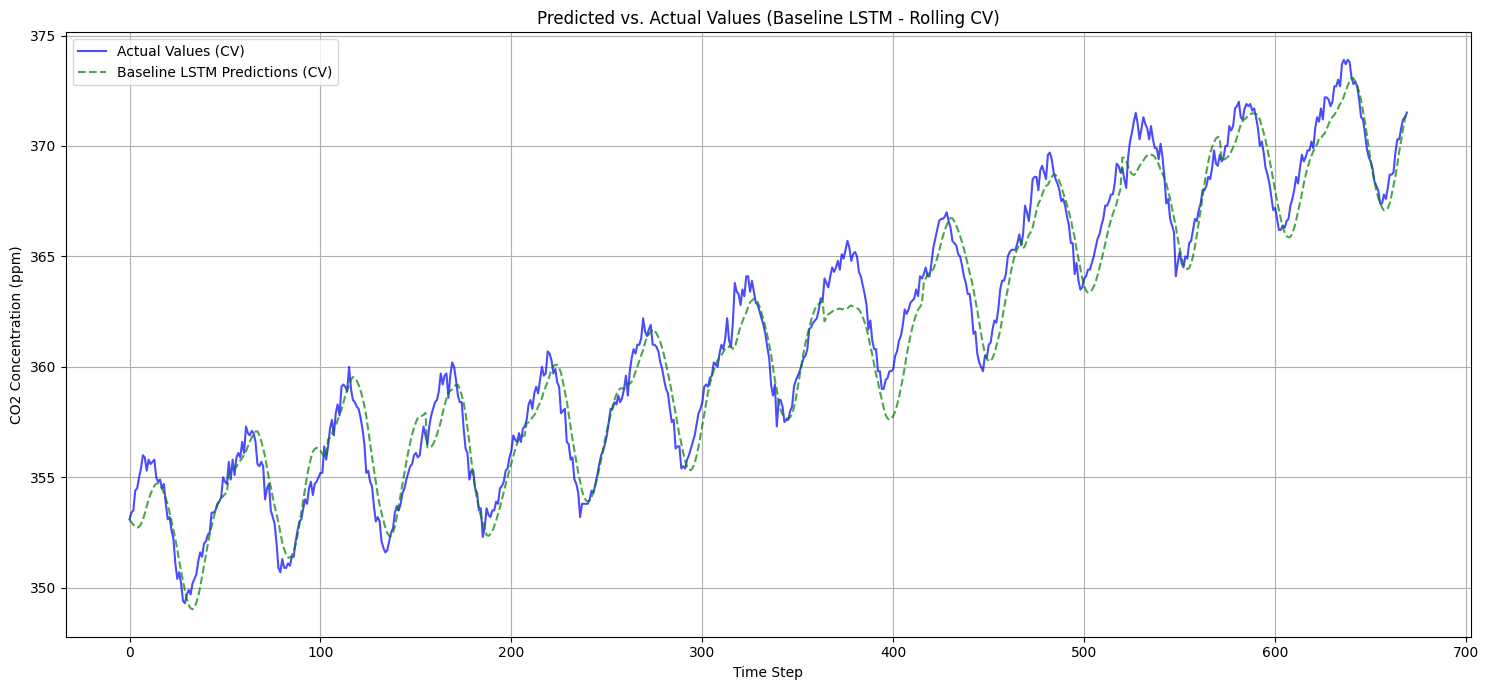

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(actual_values_cv, label='Actual Values (CV)', color='blue', alpha=0.7)
plt.plot(baseline_predictions_cv, label='Baseline LSTM Predictions (CV)', color='green', linestyle='--', alpha=0.7)
plt.title('Predicted vs. Actual Values (Baseline LSTM - Rolling CV)')
plt.xlabel('Time Step')
plt.ylabel('CO2 Concentration (ppm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='random_normal',
                                   trainable=True)
        self.b = self.add_weight(name='att_bias',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        self.u = self.add_weight(name='att_context',
                                   shape=(input_shape[-1],),
                                   initializer='random_normal',
                                   trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        att_scores = K.sum(uit * self.u, axis=-1)
        att_weights = K.softmax(att_scores, axis=1)
        att_weights = K.expand_dims(att_weights, axis=-1)
        context_vector = K.sum(x * att_weights, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_attention_model_for_cv(lstm_units, learning_rate):
    input_sequence = Input(shape=(X_reshaped.shape[1], 1), name='input_sequence_cv')
    lstm_out = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer_cv')(input_sequence)
    attention_out = Attention(name='attention_layer_cv')(lstm_out)
    output_pred = Dense(units=1, activation='linear', name='output_layer_cv')(attention_out)
    model = Model(inputs=input_sequence, outputs=output_pred, name='Attention_LSTM_Model_CV')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_baseline_model_for_cv():
    baseline_input_sequence = Input(shape=(X_reshaped.shape[1], 1), name='baseline_input_sequence_cv')
    lstm_out_baseline = LSTM(units=50, return_sequences=False, name='baseline_lstm_layer_cv')(baseline_input_sequence)
    output_pred_baseline = Dense(units=1, activation='linear', name='baseline_output_layer_cv')(lstm_out_baseline)
    model = Model(inputs=baseline_input_sequence, outputs=output_pred_baseline, name='Baseline_LSTM_Model_CV')
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lstm_units = best_hps.get('lstm_units')
best_learning_rate = best_hps.get('learning_rate')

print(f"Best Attention Model Hyperparameters: LSTM Units={best_lstm_units}, Learning Rate={best_learning_rate}")

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    return rmse, mae, mape

attention_predictions_cv = []
baseline_predictions_cv = []
actual_values_cv = []

print("\nStarting Rolling-Origin Cross-Validation...")

for train_index in range(initial_train_size, len(X_reshaped), step_size):
    predict_end_index = min(train_index + step_size, len(X_reshaped))
    if train_index >= len(X_reshaped):
        print(f"No more data for training at index {train_index}.")
        break
    if predict_end_index <= train_index:
        print(f"No data left to predict after index {train_index}.")
        break
    X_train_fold = X_reshaped[:train_index]
    y_train_fold = y[:train_index]
    X_test_fold = X_reshaped[train_index:predict_end_index]
    y_test_fold = y[train_index:predict_end_index]

    if X_train_fold.shape[0] < sequence_length:
        print(f"Skipping fold starting at {train_index} due to insufficient training data size: {X_train_fold.shape[0]}.")
        continue
    if X_test_fold.shape[0] == 0:
        print(f"Skipping fold starting at {train_index} due to no test data.")
        continue

    print(f"\n--- Fold starting at {train_index} (Train size: {X_train_fold.shape[0]}, Test size: {X_test_fold.shape[0]}) ---")
    attention_model_fold = build_attention_model_for_cv(best_lstm_units, best_learning_rate)
    print(f"Training Attention Model for fold {train_index}...")
    attention_model_fold.fit(X_train_fold, y_train_fold,
                            epochs=10,
                            batch_size=32,
                            verbose=0,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])
    attention_predictions_scaled_fold = attention_model_fold.predict(X_test_fold, verbose=0)
    baseline_model_fold = build_baseline_model_for_cv()
    print(f"Training Baseline Model for fold {train_index}...")
    baseline_model_fold.fit(X_train_fold, y_train_fold,
                           epochs=10, 
                           batch_size=32,
                           verbose=0,
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])
    baseline_predictions_scaled_fold = baseline_model_fold.predict(X_test_fold, verbose=0)
    attention_predictions_cv.extend(scaler.inverse_transform(attention_predictions_scaled_fold).flatten())
    baseline_predictions_cv.extend(scaler.inverse_transform(baseline_predictions_scaled_fold).flatten())
    actual_values_cv.extend(scaler.inverse_transform(y_test_fold.reshape(-1, 1)).flatten())

print("\nRolling-Origin Cross-Validation complete.")
actual_values_cv = np.array(actual_values_cv)
attention_predictions_cv = np.array(attention_predictions_cv)
baseline_predictions_cv = np.array(baseline_predictions_cv)
actual_values_cv[actual_values_cv == 0] = np.finfo(float).eps

rmse_att_cv, mae_att_cv, mape_att_cv = calculate_metrics(actual_values_cv, attention_predictions_cv, "Attention-based LSTM (Rolling CV)")
rmse_base_cv, mae_base_cv, mape_base_cv = calculate_metrics(actual_values_cv, baseline_predictions_cv, "Baseline LSTM (Rolling CV)")

Best Attention Model Hyperparameters: LSTM Units=64, Learning Rate=0.01

Starting Rolling-Origin Cross-Validation...

--- Fold starting at 1562 (Train size: 1562, Test size: 52) ---
Training Attention Model for fold 1562...
Training Baseline Model for fold 1562...

--- Fold starting at 1614 (Train size: 1614, Test size: 52) ---
Training Attention Model for fold 1614...
Training Baseline Model for fold 1614...

--- Fold starting at 1666 (Train size: 1666, Test size: 52) ---
Training Attention Model for fold 1666...
Training Baseline Model for fold 1666...

--- Fold starting at 1718 (Train size: 1718, Test size: 52) ---
Training Attention Model for fold 1718...
Training Baseline Model for fold 1718...

--- Fold starting at 1770 (Train size: 1770, Test size: 52) ---
Training Attention Model for fold 1770...
Training Baseline Model for fold 1770...

--- Fold starting at 1822 (Train size: 1822, Test size: 52) ---
Training Attention Model for fold 1822...
Training Baseline Model for fold 182